In [1]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split


ImportError: Traceback (most recent call last):
  File "C:\python310\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [18]:
from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

In [19]:
from sklearn import set_config
set_config(print_changed_only = False)
directory = "/chest_xray/"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


<h1>Loading Dataset</h1>

In [32]:
%%time

train_df = glob.glob("chest_xray/train/**/*.jpeg")
test_df = glob.glob("chest_xray/test/**/*.jpeg")
validation_df = glob.glob("chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: total: 15.6 ms
Wall time: 29.1 ms


In [33]:

train_df[:5], test_df[:5]

(['chest_xray/train\\NORMAL\\IM-0115-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0117-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0119-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0122-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0125-0001.jpeg'],
 ['chest_xray/test\\NORMAL\\IM-0001-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0003-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0005-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0006-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0007-0001.jpeg'])

In [34]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [39]:
import os
import glob
from termcolor import colored

# Define the root directory where the datasets are stored
directory = "chest_xray"  # Adjust the path as necessary

datasets = ["train", "test", "val"]
normal_lung, pneumonia_lung = [], []

for i in datasets:
    path = os.path.join(directory, i)
    print(f"Checking in path: {path}")  # Debugging line
    
    # Look for .jpeg files in the NORMAL and PNEUMONIA folders
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    
    # Debugging lines to check how many files are found
    print(f"Found {len(normal)} normal images in {path}")
    print(f"Found {len(pneumonia)} pneumonia images in {path}")

    normal_lung.extend(normal)
    pneumonia_lung.extend(pneumonia)

# Print the counts of the images found
print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))


Checking in path: chest_xray\train
Found 1341 normal images in chest_xray\train
Found 3875 pneumonia images in chest_xray\train
Checking in path: chest_xray\test
Found 234 normal images in chest_xray\test
Found 390 pneumonia images in chest_xray\test
Checking in path: chest_xray\val
Found 8 normal images in chest_xray\val
Found 8 pneumonia images in chest_xray\val
The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


<h2>Shuffle the images</h2>

In [40]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['chest_xray\\train\\NORMAL\\NORMAL2-IM-0825-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-0558-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-1250-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-0589-0001.jpeg',
 'chest_xray\\test\\NORMAL\\NORMAL2-IM-0146-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0446-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0274-0001.jpeg',
 'chest_xray\\test\\NORMAL\\NORMAL2-IM-0351-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0494-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0709-0001.jpeg']

NORMAL


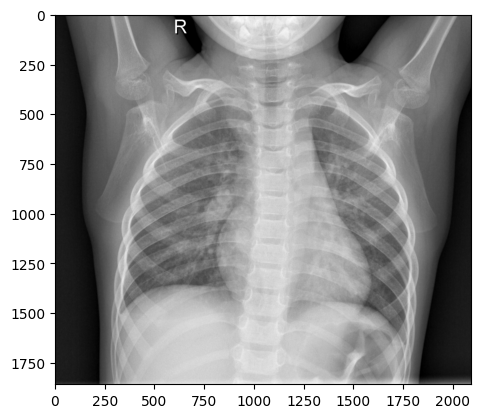

In [41]:
normal_lung_image = load_img("chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


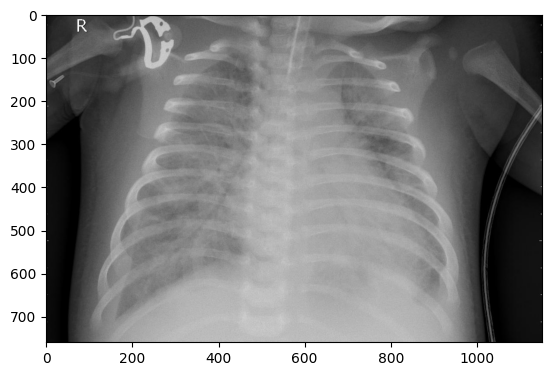

In [83]:
pneumonia_lung_image = load_img("chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(pneumonia_lung_image)
plt.show()

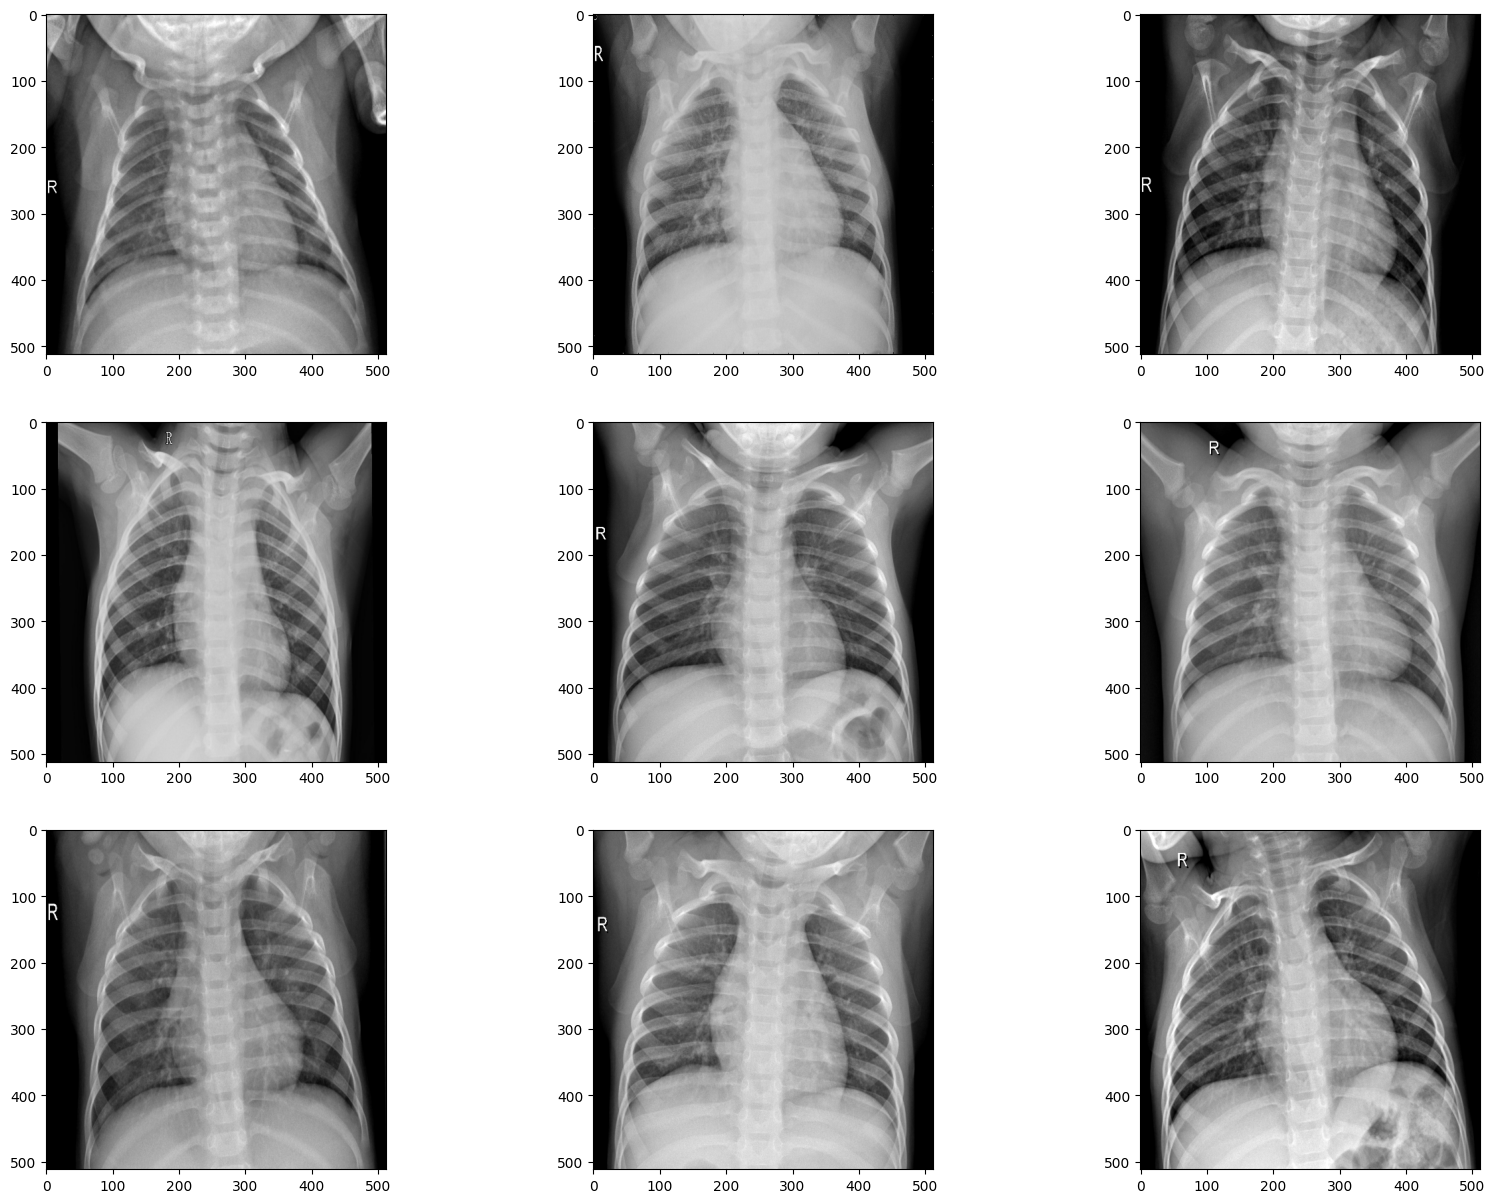

In [43]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

<h2>Image erosion</h2> 

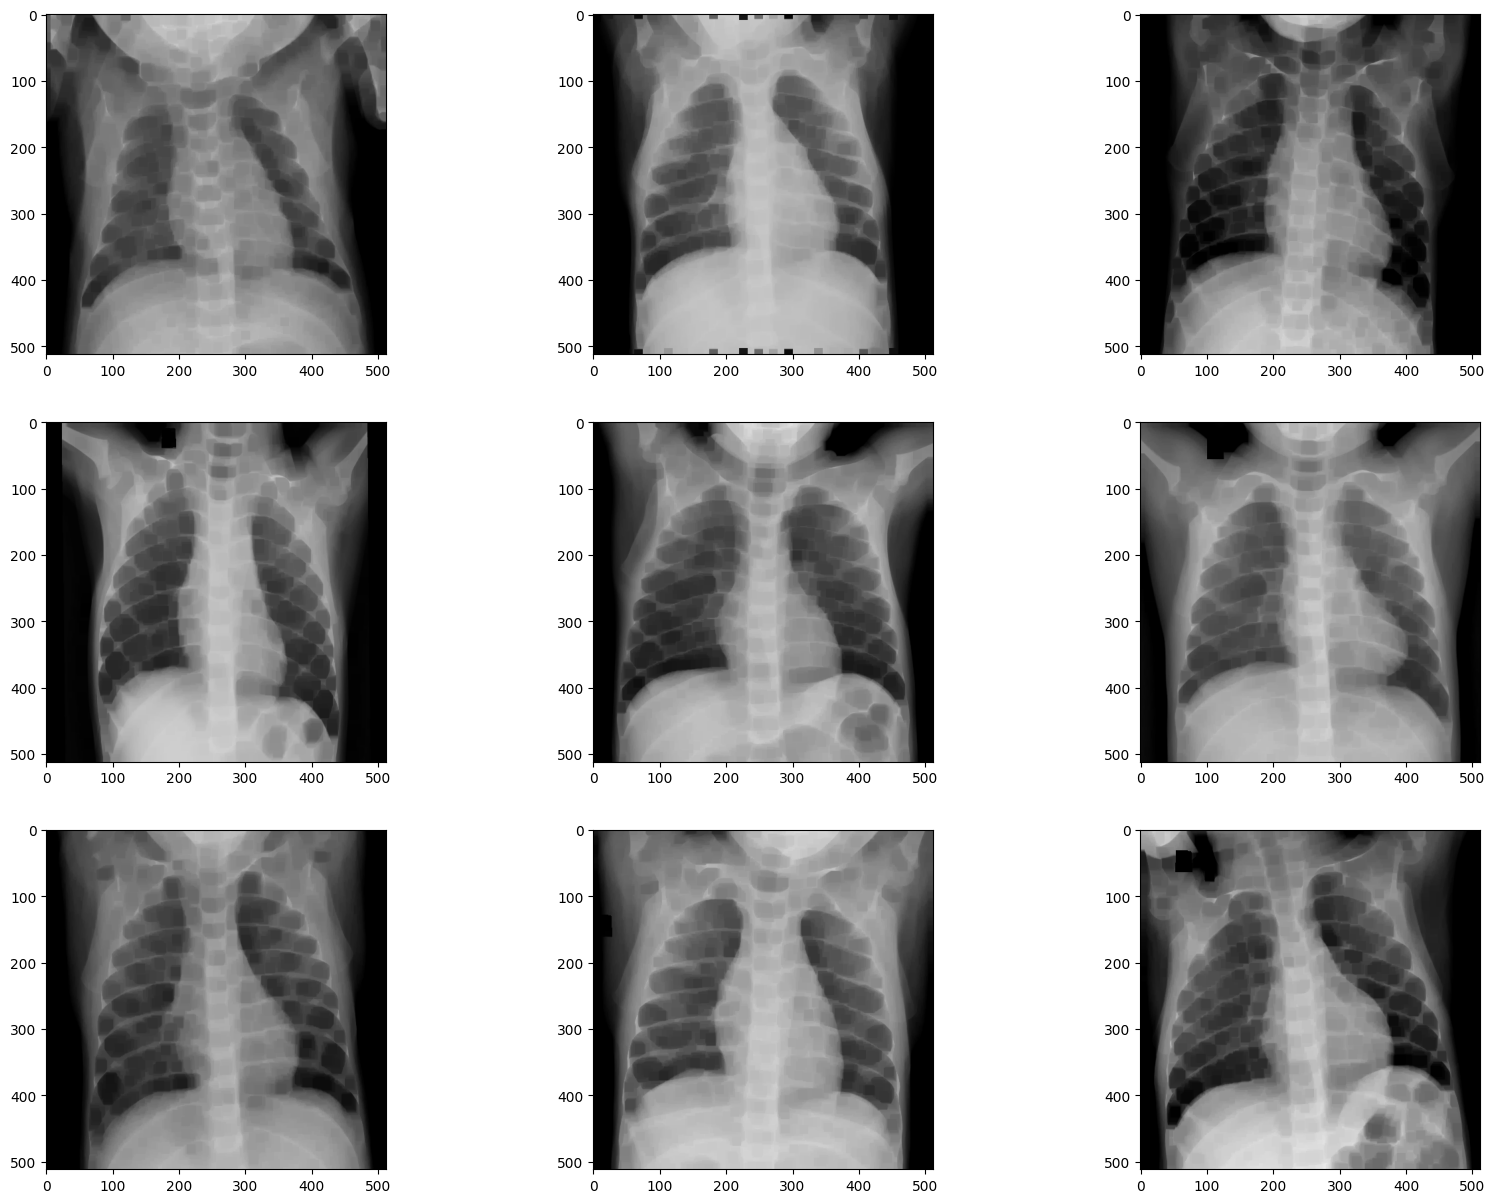

In [44]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

<h2>Image dilation</h2>

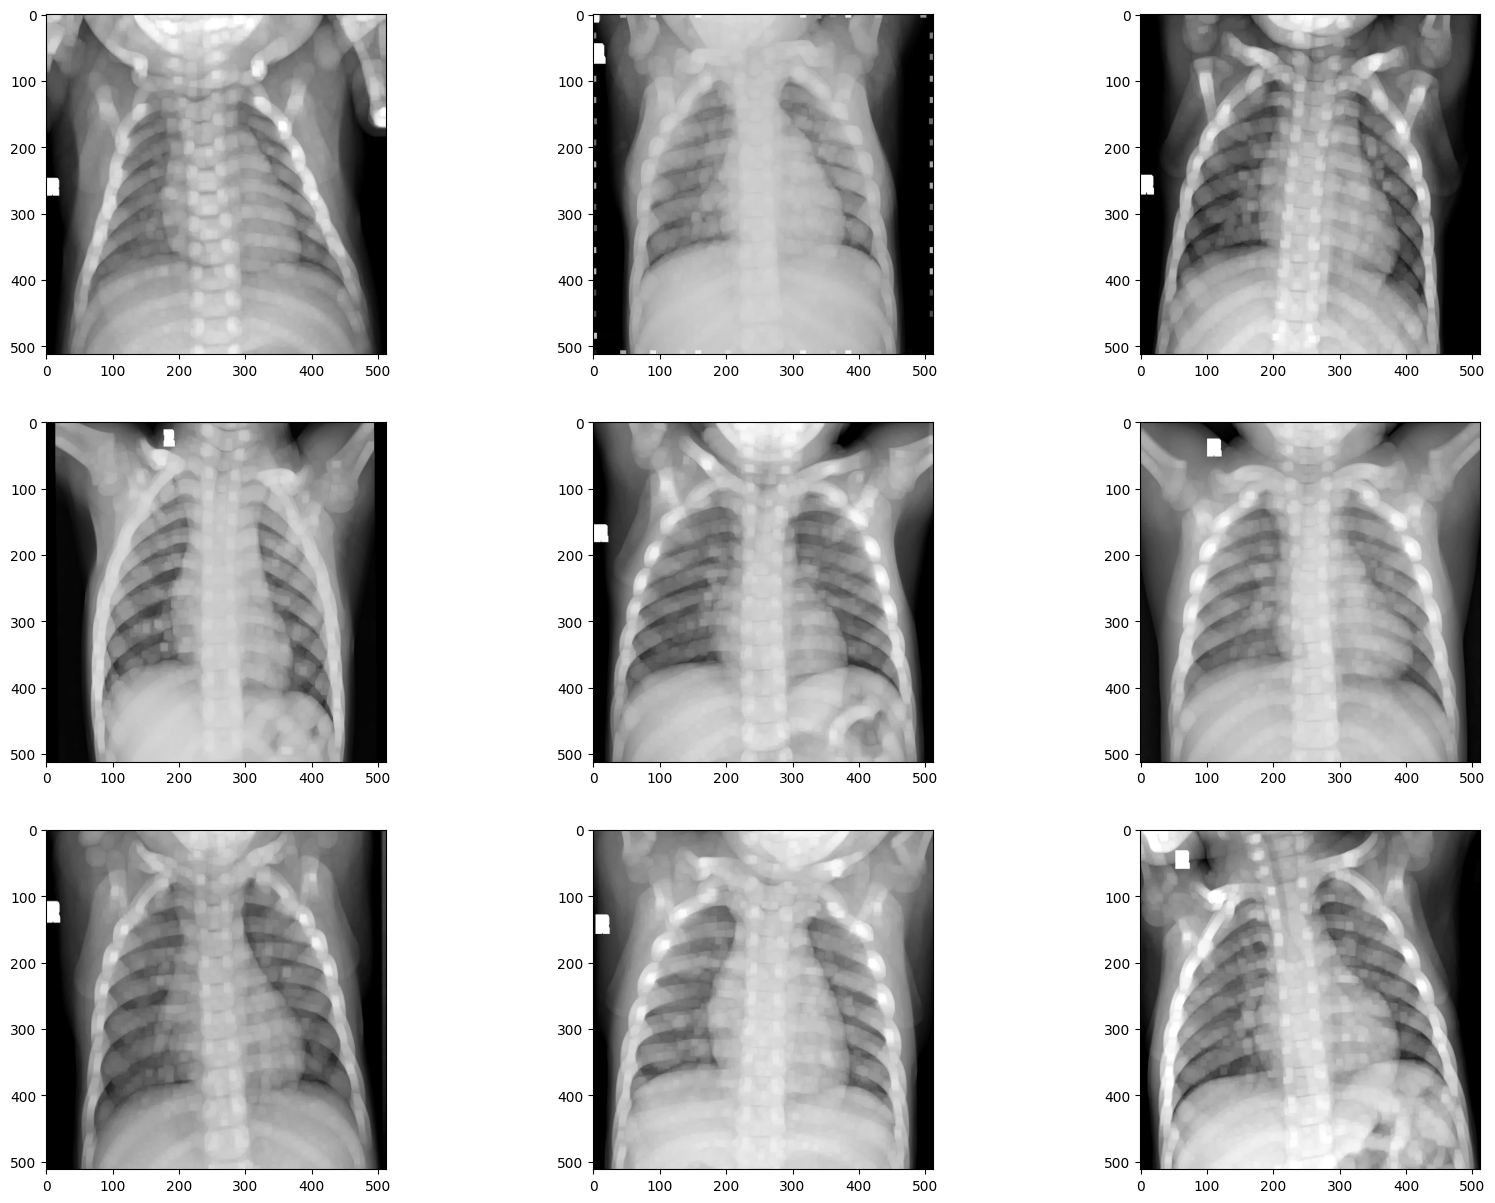

In [45]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

<h2>Converting the images to greyscale and then apply Gaussian blur to them</h2>

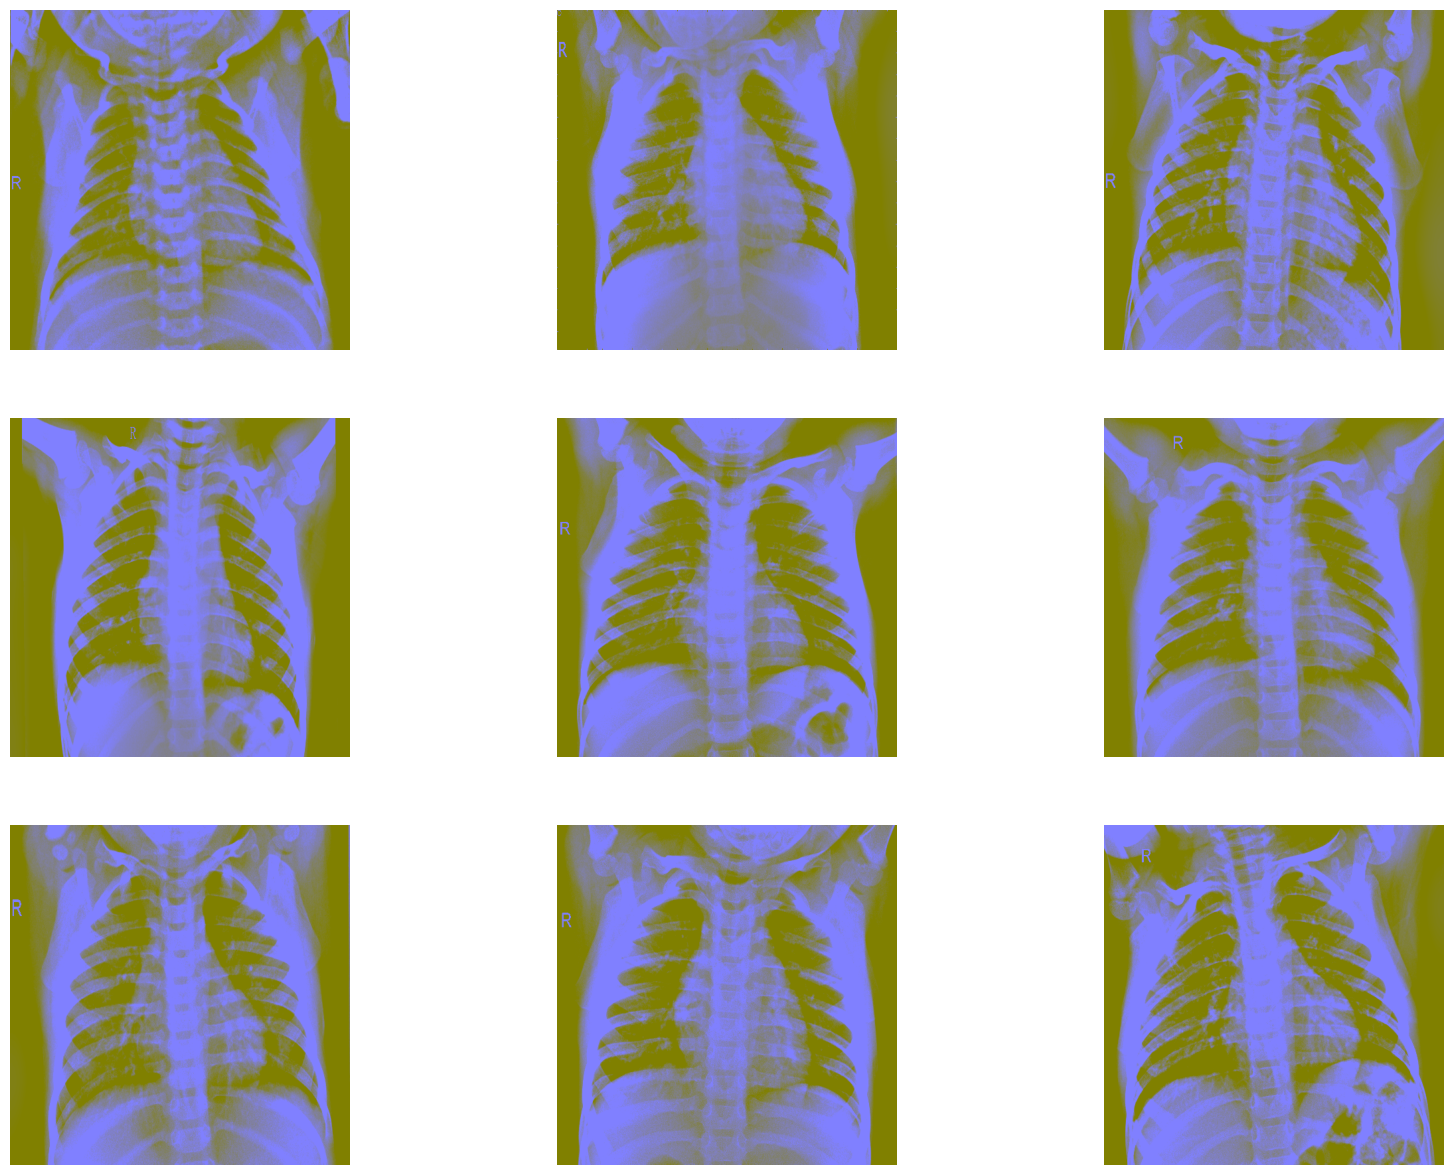

In [46]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

<h2>Canny edge detection: </h2>

Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems

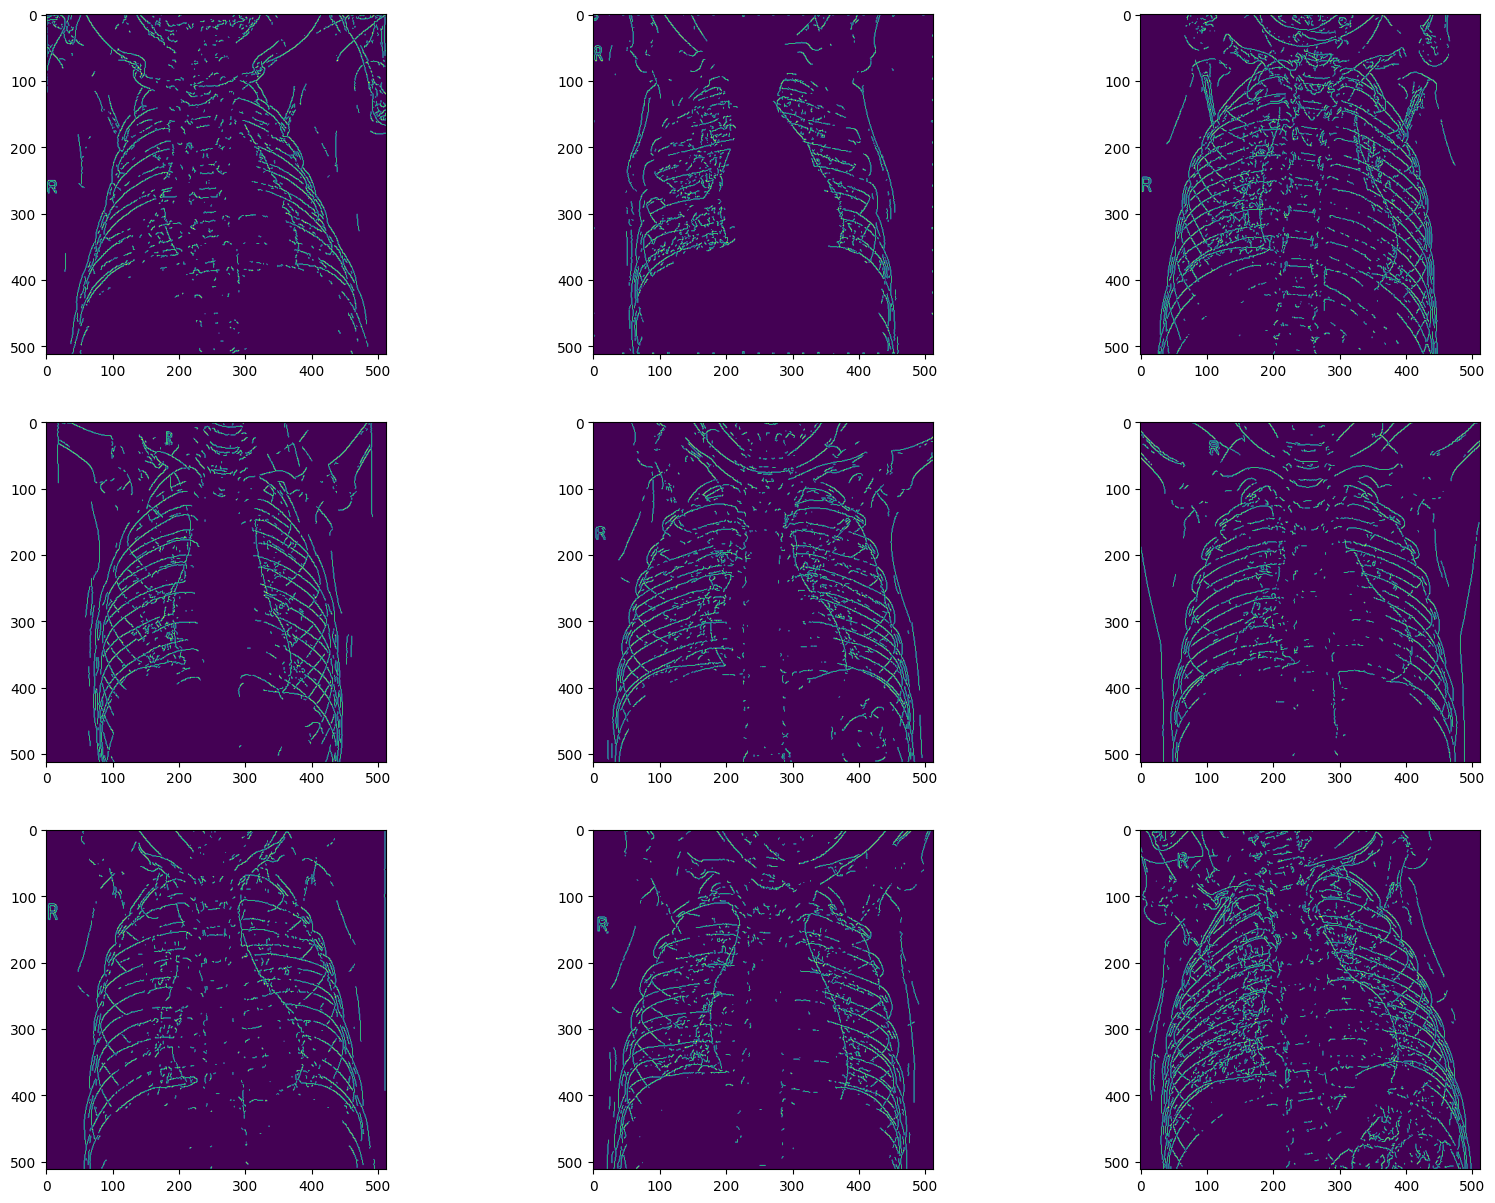

In [47]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

<h2>Building deep learning models </h2>

In [48]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
validation_dir = "chest_xray/val"

In [49]:
%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)
val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))


Found 5216 images belonging to 2 classes.


C:\python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:1047: UserWarning:

This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.



Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
CPU times: total: 141 ms
Wall time: 221 ms


In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Correct import

# Now you can proceed to use image_dataset_from_directory


In [58]:
# Load the datasets using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Resize images to a consistent size
    batch_size=32,          # Batch size
    label_mode='int',       # or 'categorical', depending on your labels
    shuffle=True            # Shuffle the dataset
)

val_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False           # Validation data should not be shuffled
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False
)

# Caching and prefetching for optimization
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Print out the dataset shapes to verify
print(train_dataset)
print(val_dataset)
print(test_dataset)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<h2>Building CNN model</h2>

In [59]:
model1 = Sequential()

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (224, 224, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

#fully connected layer
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,821,441 (26.02 MB)

 Trainable params: 6,821,441 (26.02 MB)

 Non-trainable params: 0 (0.00 B)

<h2>Compile the model</h2>

In [60]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

<h2>Train the model</h2>

In [61]:
%%time

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [63]:
%%time

history = model1.fit(train_set, epochs = 20,
                              validation_data = validation_set,
                              steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

C:\python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

C:\python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

C:\python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:1286: UserWarning:

This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 547ms/step - accuracy: 0.6827 - loss: 0.6852 - val_accuracy: 0.5000 - val_loss: 0.6978
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 557ms/step - accuracy: 0.7629 - loss: 0.4561 - val_accuracy: 0.6250 - val_loss: 0.5684
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.8090 - loss: 0.3982 - val_accuracy: 0.6250 - val_loss: 0.9473
Epoch 4/20
 26/100 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.7907 - loss: 0.3765

C:\python310\lib\contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.7712 - loss: 0.3972 - val_accuracy: 0.6875 - val_loss: 0.5355
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 557ms/step - accuracy: 0.8152 - loss: 0.4075 - val_accuracy: 0.7500 - val_loss: 0.4992
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 903ms/step - accuracy: 0.8430 - loss: 0.3355 - val_accuracy: 0.6250 - val_loss: 1.3983
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8378 - loss: 0.3495 - val_accuracy: 0.6250 - val_loss: 1.2941
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.8459 - loss: 0.3618 - val_accuracy: 0.7500 - val_loss: 0.7052
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8495 - loss: 0.3157 - val_accuracy: 0.7500 - val_loss: 0.6640
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 97s 976ms/step - accuracy: 0.8749 - loss: 0.2714 - val_accuracy: 0.7500 - val_loss: 0.4637
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 960ms/step - accuracy: 0.8512 - loss: 0.3132 - val_a

<h2>Visualizing the performance of model1</h2>

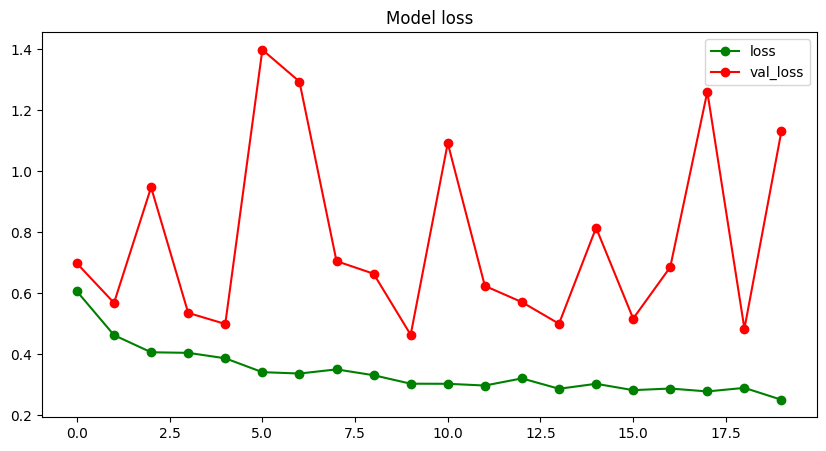

In [65]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

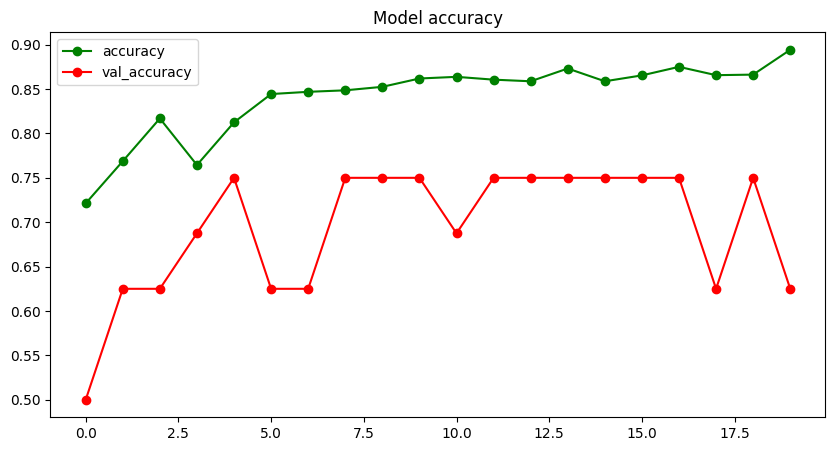

In [66]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

<h2>Evaluating model1 on the test set</h2>

In [67]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.7507 - loss: 0.4726
The testing accuracy is:  75.64102411270142 %
The testing loss is:  46.6105192899704 %


<h1>VGG16 model</h1>

In [68]:
base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max",
                    classes = 2)

#base_model1.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
base_model1.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [70]:
%%time

history = model2.fit(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                               callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7766 - loss: 0.4929 - val_accuracy: 0.6875 - val_loss: 0.4269
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8562 - loss: 0.3066 - val_accuracy: 0.7500 - val_loss: 0.4760
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.8835 - loss: 0.2509 - val_accuracy: 0.7500 - val_loss: 0.7722
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 548ms/step - accuracy: 0.8678 - loss: 0.2701 - val_accuracy: 0.7500 - val_loss: 0.5595
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8814 - loss: 0.2733 - val_accuracy: 0.7500 - val_loss: 0.5728
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8993 - loss: 0.2430 - val_accuracy: 0.7500 - val_loss: 0.8537
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8905 - loss: 0.2549 - val_accuracy: 0.7500 - val_loss: 0.4553
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 536ms/step - accuracy: 0.8857 - loss: 0.2554 - val_

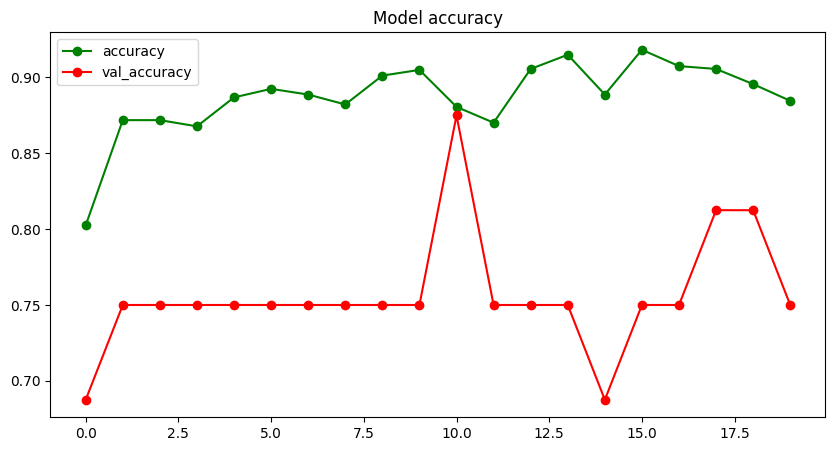

In [71]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

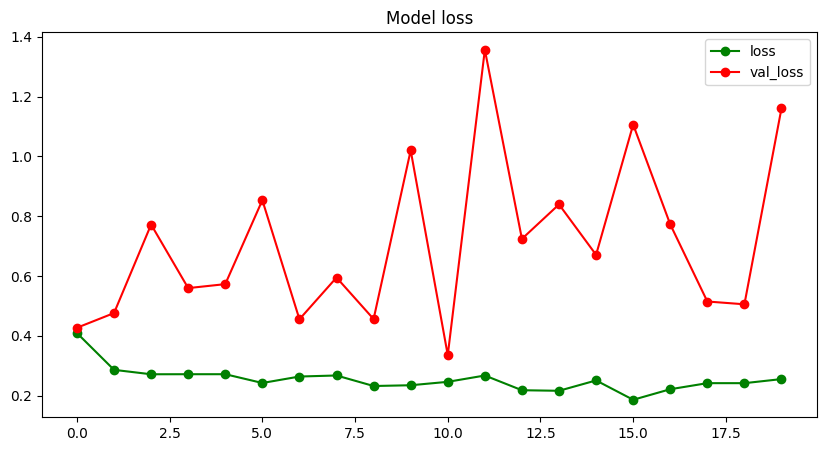

In [72]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [73]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6980 - loss: 0.5001
The testing accuracy is:  70.83333134651184 %
The testing loss is:  50.09570121765137 %


<h1>ResNet50V2 model</h1>

In [74]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False
    
#base_model2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 49s 1us/step


In [75]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [76]:
%%time

history = model3.fit(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 750ms/step - accuracy: 0.7893 - loss: 0.6897 - val_accuracy: 0.7500 - val_loss: 0.2867
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 781ms/step - accuracy: 0.8567 - loss: 0.3551 - val_accuracy: 0.8750 - val_loss: 0.2299
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 785ms/step - accuracy: 0.8965 - loss: 0.2713 - val_accuracy: 0.9375 - val_loss: 0.1836
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.8868 - loss: 0.2778 - val_accuracy: 0.8750 - val_loss: 0.2382
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 750ms/step - accuracy: 0.9286 - loss: 0.1922 - val_accuracy: 0.8750 - val_loss: 0.1916
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 760ms/step - accuracy: 0.9185 - loss: 0.2012 - val_accuracy: 0.8125 - val_loss: 0.4300
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 748ms/step - accuracy: 0.9030 - loss: 0.2183 - val_accuracy: 0.8750 - val_loss: 0.3287
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9492 - loss: 0

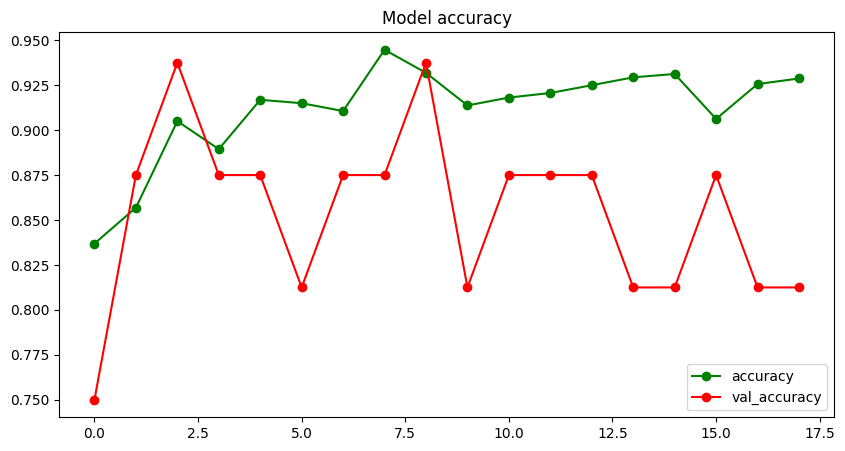

In [77]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

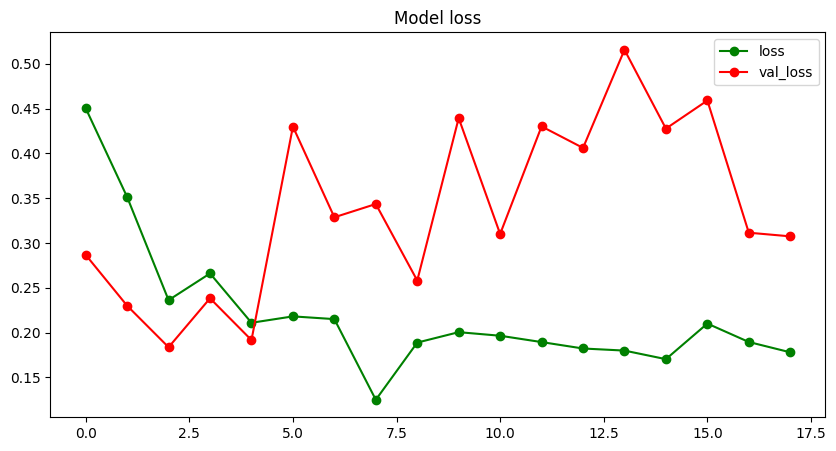

In [78]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [79]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.9126 - loss: 0.2502
The testing accuracy is:  89.58333134651184 %
The testing loss is:  29.3175607919693 %


<h2>Prediction of a new image</h2>

In [91]:
%%time

new_image_path = "D:\SEM 5\DIP\Project\person1946_bacteria_4874.jpeg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255
#___________________________________________________________________

result = model3.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
P N E U M O N I A
CPU times: total: 1.27 s
Wall time: 1.61 s


In [92]:
model3.save("my_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

Model3 was succesfully saved to disk...


In [93]:
model_loaded = tensorflow.keras.models.load_model("my_pneumonia_detection_model.h5")
model_loaded.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,837,443 (90.93 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 51.110 percent P N E U M O N I A


C:\Users\Jatin\AppData\Local\Temp\ipykernel_28948\2583164652.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



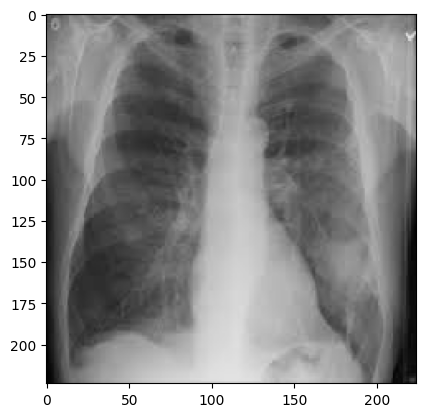

In [96]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("my_pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100 
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))
     
 
# call and use the function
image_prediction("image.jpeg")

In [97]:
test_dir = "chest_xray/test"
test_data, test_labels = [], []

In [98]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

_______C o n f u s i o n   m a t r i x_______

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


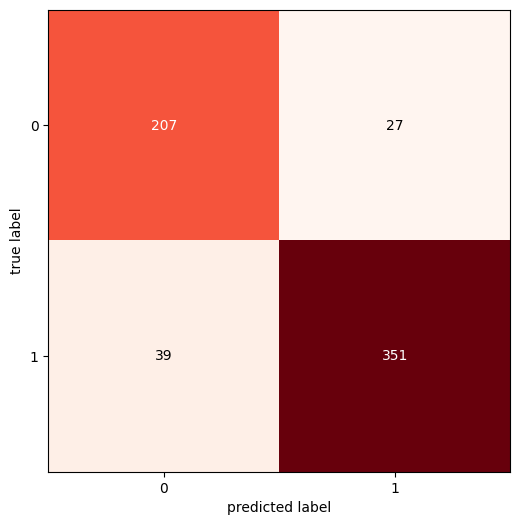

In [99]:
print("_______C o n f u s i o n   m a t r i x_______\n")

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()

In [100]:
%%time

precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))  

Accuracy: 89.42307692307693%
Precision: 92.85714285714286%
Recall: 90.0%
F1-score: 91.40625
CPU times: total: 0 ns
Wall time: 0 ns


In [106]:
predictions = list()
preds = model_loaded.predict(test_data)
for i in preds:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [107]:
correct_predictions = np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

# let's look at indices of correct predictions
print("Indices of correct predictions:\n", correct_predictions[:15])

# let's look at indices of incorrect correct predictions
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Indices of incorrect predictions:
 [ 45  47  67 115 119 122 126 129 131 132 133 134 136 140 143]


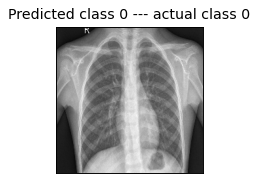

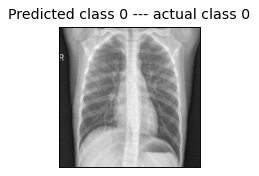

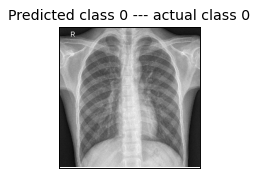

In [108]:
# display correct predictions

i = 0
for a in correct_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

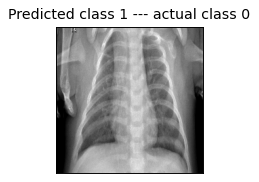

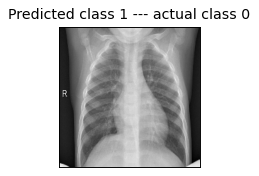

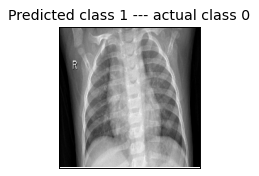

In [109]:
# display incorrect predictions

i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1